In [1]:
import os
import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle
from wordcloud import WordCloud

In [2]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

In [3]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [4]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [5]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [6]:
def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [7]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [8]:
LOAD_CLUSTERS_DATA = True

In [9]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_rus_usernames:
        ukraine_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_ukr_usernames:
        ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [10]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [11]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [12]:
if not LOAD_CLUSTERS_DATA:
    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [13]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [14]:
def get_user_followers(user_name, user_id, num_pages=1):
    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes
    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = 1000, limit = num_pages).flatten()
    for follower in followers_paginator:
        followers.append(follower)
    return (user_name, user_id), followers

In [15]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [16]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [17]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

'''
for cluster in russia_sources_rus:
    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_rus:
    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_ukr:
    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_eng:
    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))
'''

'\nfor cluster in russia_sources_rus:\n    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_rus:\n    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_ukr:\n    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_eng:\n    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n'

In [18]:
# TEST CODE: 1000 followers per cluster, 2 cluster per each
for i in range(0, 2):
    rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

for i in range(0, 2):
    ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))

In [19]:
print(ukr_eng_cluster_followers)

[(('@dmitry_gordon', 1334400780), [<User id=2474463449 name=Наталiя username=NataliU1402>, <User id=1477748411449360399 name=Данило username=Danilo45453076>, <User id=1598450403192066060 name=Максим (Higansakal) username=higansakal>, <User id=1507463264120328192 name=Олександр username=OleksandrAvram9>, <User id=1518651422597857283 name=RedDragon username=LadyLali8>, <User id=1598444389881335816 name=Slava Nort username=NortSlava>, <User id=1213417223387136000 name=andromikadze username=andromikadze1>, <User id=1598433134181228553 name=Александр username=Aleksan62382640>, <User id=1593656552971505667 name=Olga Uyusova username=OUyusova>, <User id=1598425531694850059 name=Сезен username=li48296603>, <User id=1598422771918409729 name=Bogdan username=bohdanraiskiy>, <User id=1578709585501765643 name=Anzhela Zholya username=anzhela_zholya>, <User id=1598418856749441035 name=Sanya Ivanov username=SanyaIv83251758>, <User id=2396306528 name=Владислав Водопьян username=wodo73>, <User id=149647

In [20]:
'''
print(type(followers[('@minregion_ua', 3333475643)][0]))
print(followers[('@minregion_ua', 3333475643)][0].name)
print(followers[('@minregion_ua', 3333475643)][0].id)
'''

"\nprint(type(followers[('@minregion_ua', 3333475643)][0]))\nprint(followers[('@minregion_ua', 3333475643)][0].name)\nprint(followers[('@minregion_ua', 3333475643)][0].id)\n"

In [21]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [22]:
def cluster_to_df(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [23]:
rus_cluster = cluster_to_df(rus_cluster_followers)
ukr_eng_cluster = cluster_to_df(ukr_eng_cluster_followers)
ukr_rus_cluster = cluster_to_df(ukr_rus_cluster_followers)
ukr_ukr_cluster = cluster_to_df(ukr_ukr_cluster_followers)

In [24]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [25]:
clusters_to_files(rus_cluster)
clusters_to_files(ukr_eng_cluster)

<h2>Visualizing Connections as a Graph</h2>

In [26]:
ukr_eng_cluster[('@dmitry_gordon',
  1334400780)]

,username,user_id
0,Наталiя,2474463449
1,Данило,1477748411449360399
2,Максим (Higansakal),1598450403192066060
3,Олександр,1507463264120328192
4,RedDragon,1518651422597857283
...,...,...
994,Sergey63,1595247013184126977
995,radiance🌙,1595244393308585985
996,Я В ПОРЯДЕ ...,1595242950312824833
997,Junihofasunine,1595241127162138630


In [27]:
import networkx as nx

In [28]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [29]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [30]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

In [31]:
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster",
                                              global_graph_pd)

In [95]:
print(global_graph_pd.size)
print(set(global_graph_pd['cluster_name']))

12000
{'@SvobodaRadio', '@ru_rbc'}


In [33]:
global_graph_pd_columns = list(global_graph_pd.columns)

In [34]:
print("Constructing NetworkX graph")

# what if you store all attributes as edge attributes?
G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', edge_attr = global_graph_pd_columns,
                             create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


Visualizing a small subset of connections...


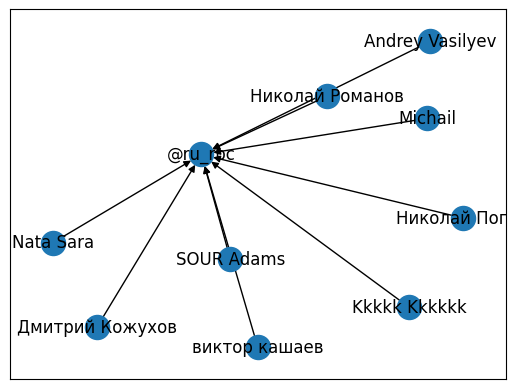

In [35]:
print("Visualizing a small subset of connections...")

subgraph = G.subgraph(list(G.nodes)[:10])

subgraph_pos = nx.spring_layout(subgraph)

nx.draw_networkx(subgraph, subgraph_pos)

<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

3. Do nodes cluster into tightly connected groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing (Use entity recognition)?

2. Tag Cloud: who are people within each group discussing?

3. What sentiment do mentions within each groups have?

4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)

<h2>Visualization Techniques that can be leveraged</h2>
1. Network Visualization

2. Coloring nodes

3. Coloring Connections

4. Size of the nodes

5. Shape of the nodes


In [36]:
def get_edge_attributes(graph, attr_list):
    KEY = 0
    VALUE = 1
    edge_attrs = {}
    for attr in attr_list:
        edges_attribute = nx.get_edge_attributes(graph, attr)
        for edge_attr in edges_attribute.items():
            if edge_attr[KEY] in edge_attrs.keys():
                edge_attr_values = edge_attrs[edge_attr[KEY]]
                edge_attr_values.append(edge_attr[VALUE])
                edge_attrs[edge_attr[KEY]] = edge_attr_values
            else:
                edge_attrs[edge_attr[KEY]] = [edge_attr[VALUE]]
    return edge_attrs

edge_attrs = get_edge_attributes(subgraph, global_graph_pd_columns)

print(edge_attrs)

{('Andrey Vasilyev', '@ru_rbc'): ['Andrey Vasilyev', 1598480167470514176, '@ru_rbc', 269770723, 535690, 0], ('Дмитрий Кожухов', '@ru_rbc'): ['Дмитрий Кожухов', 1580213299169353728, '@ru_rbc', 269770723, 535690, 0], ('Michail', '@ru_rbc'): ['Michail', 1598480545188560897, '@ru_rbc', 269770723, 535690, 0], ('Kkkkk Kkkkkk', '@ru_rbc'): ['Kkkkk Kkkkkk', 1598490898781839360, '@ru_rbc', 269770723, 535690, 0], ('SOUR Adams', '@ru_rbc'): ['SOUR Adams', 1597419145859039232, '@ru_rbc', 269770723, 535690, 0], ('виктор кашаев', '@ru_rbc'): ['виктор кашаев', 2315178207, '@ru_rbc', 269770723, 535690, 0], ('Николай Романов', '@ru_rbc'): ['Николай Романов', 1598478730418061312, '@ru_rbc', 269770723, 535690, 0], ('Nata Sara', '@ru_rbc'): ['Nata Sara', 1598447680971329552, '@ru_rbc', 269770723, 535690, 0], ('Николай Попов', '@ru_rbc'): ['Николай Попов', 1598463729032724483, '@ru_rbc', 269770723, 535690, 0]}


In [37]:
print("Running analysis on the network...")

# https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781789955316/7

Running analysis on the network...


In [38]:
import networkx.algorithms.community as nxcom

# identifying communities within the network
twitter_communities = sorted(nxcom.greedy_modularity_communities(G), key=len,
                             reverse=True)

In [39]:
print("The number of communities detected is ", len(twitter_communities))

The number of communities detected is  2


In [40]:
print("Visualizing Identified Communities")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

Visualizing Identified Communities


In [41]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [42]:
# Set node and edge communities
set_node_community(G, twitter_communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]

internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

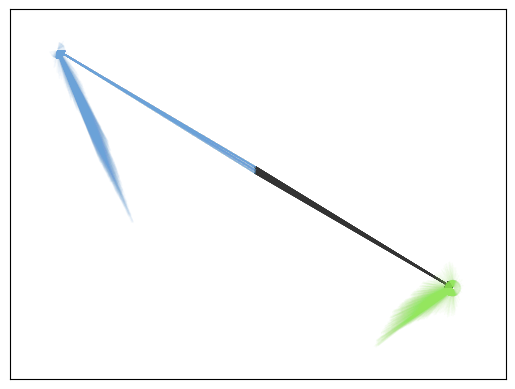

In [43]:
# Draw external edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)

In [109]:
all_clusters = []

all_clusters.extend(rus_cluster)
all_clusters.extend(ukr_eng_cluster)
all_clusters.extend(ukr_rus_cluster)
all_clusters.extend(ukr_ukr_cluster)

all_clusters_dict = {}

for cluster in all_clusters:
    if str(cluster[0]) in G.nodes:
        all_clusters_dict[str(cluster[0])] = str(cluster[0])

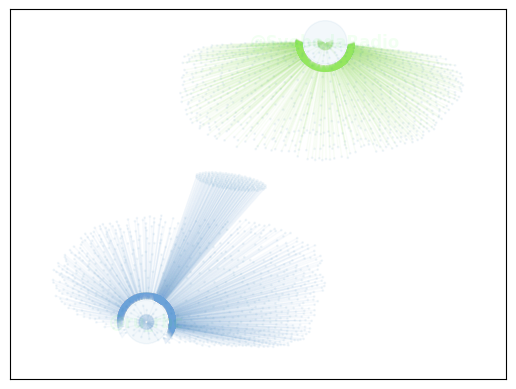

In [110]:
# TODO: ADD CLUSTER LABELS TO THE VISUALIZATION BELOW
pos = nx.spring_layout(G, k=0.15)

G_node_degrees = dict(G.degree)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=[v * 1 for v in G_node_degrees.values()],
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=True, label='Group Follower Clusters',
    labels=all_clusters_dict, font_color='#00ff00', font_weight='bold')

In [111]:
def sort_graph_by_deg_desc(graph):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

In [112]:
G_deg_sorted = sort_graph_by_deg_desc(G)

In [113]:
print("Performing connectivity analysis on a graph")

node_connections = nx.all_pairs_node_connectivity(subgraph)

Performing connectivity analysis on a graph


In [56]:
def get_shared_nodes_within_group(node_connections, group_members):
    shared_connections = []
    for username, connections_dict in node_connections.items():
        for group_member in group_members:
            if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                shared_connections.append(username)
    return shared_connections

In [57]:
get_shared_nodes_within_group(node_connections, rus_cluster)

[]

In [61]:
def get_shared_nodes_between_groups(node_connections, cluster_groups):
    shared_connections = {}
    for username, connections_dict in node_connections.items():
        for group_name, group_members in cluster_groups.items():
            for group_member in group_members:
                if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                    if group_name not in shared_connections.keys():
                        shared_connections.append(username)
                    else:
                        shared_connections[group_name] = shared_connections[group_name].append(username)
    return shared_connections

In [62]:
TWITTER_CLUSTER_GROUPS = {
    "rus_cluster": russia_sources_rus,
    "ukr_eng_cluster": ukraine_sources_rus,
    "ukr_rus_cluster": ukraine_sources_ukr,
    "ukr_ukr_cluster": ukraine_sources_eng
}

In [63]:
shared_connections_between_groups = get_shared_nodes_between_groups\
(node_connections, TWITTER_CLUSTER_GROUPS)

In [64]:
shared_connections_between_groups

{}

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127464 (\N{REGIONAL INDICATOR SYMBOL LETTER C}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128038 (\N{BIRD}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_

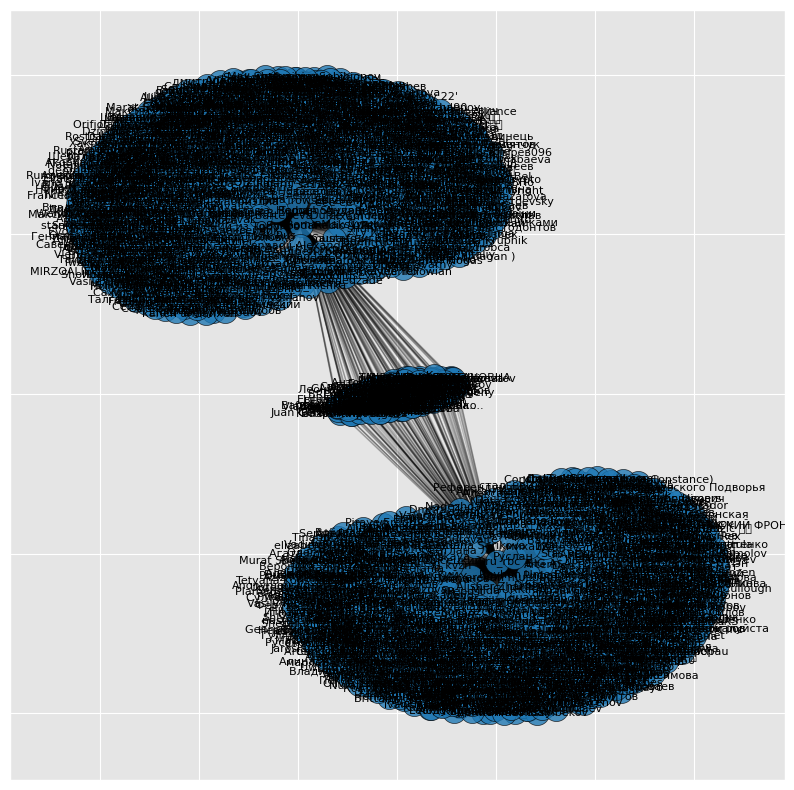

In [164]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

In [ ]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

<h2>Visualizing the Network using Gephi</h2>

In [ ]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group

<h2>Visualizing the Network using Neo4j</h2>

<h2>Analyzing group sentiments</h2>

In [ ]:
def get_tweets_for_user(username, entities, until_date, num_tweets):

    search_query = username + " OR "

    # include all possible candidate names in a query
    for entity in entities:
        search_query += "entity:" + '"' + entity + '"' + " OR "

    # remove the last OR statement
    search_query = search_query[:-3]

    search_query += "-is:retweet"

    tweets = api.search_tweets(q = search_query, count = num_tweets,
                               until=until_date,
                               tweet_mode="extended")
    return tweets

In [ ]:
UNTIL = "2022-10-11"

# Sentiment in relation to a different group

# Tweets word Cloud

# Tweets HashTags Word Cloud

# Tweets events mapping? (Maybe)

In [2]:
# https://www.caida.org/catalog/software/walrus/